In [1]:
# Importing Dependencies
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


In [48]:
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

In [3]:
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [4]:
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.layers import Dropout

Data Preparation

In [5]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files = True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete3VK54D/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [6]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [7]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [8]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

Dataset Visualization

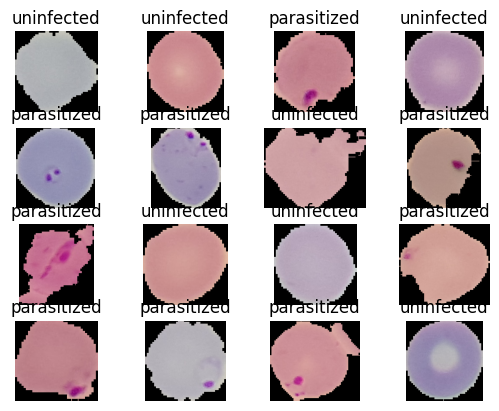

In [9]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

Data Preprocessing

In [10]:
@tf.function
def resize_rescale(image, label):
  #print("I was here")
  #tf.print("I was here")
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [11]:
IM_SIZE = 224
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [12]:
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

CSVLogger



In [13]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)

EarlyStopping

In [33]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=6, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

LearningRateScheduler

In [ ]:
# def scheduler(epoch, lr):

#   if epoch <= 3:
#     learning_rate = lr
#   else:
#     learning_rate = lr * tf.math.exp(-0.1)
#     learning_rate = learning_rate.numpy()

#   with train_writer.as_default():
#     tf.summary.scalar('Learning Rate', data = learning_rate, step = epoch)
#   return learning_rate
# scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

ModelCheckpointing

In [15]:
checkpoint_callback = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_precision', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch',
)

ReduceLearningRateOnPlateau

In [32]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.2, patience=4, verbose=1
)

Model Building

Sequential API

In [28]:
model = tf.keras.Sequential([
    InputLayer(input_shape= (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu' ),
    BatchNormalization(),
    MaxPool2D(pool_size= 2, strides= 2 ),
    # Dropout(rate = 0.4),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size= 2, strides= 2 ),
    # Dropout(rate = 0.35),

    Flatten(),

    Dense(100, activation = 'relu'),
    BatchNormalization(),
    # Dropout(rate = 0.25),

    Dense(10, activation = 'relu', ),
    BatchNormalization(),
    # Dropout(rate = 0.15),

    Dense(1, activation = 'sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_12 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_13 (Bat  (None, 109, 109, 16)     64        
 chNormalization)                                                
                                                      

Functional API

In [ ]:
# func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

# x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input)
# x = BatchNormalization()(x)
# x = MaxPool2D (pool_size = 2, strides= 2)(x)

# x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
# x = BatchNormalization()(x)
# output = MaxPool2D (pool_size = 2, strides= 2)(x)

# feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")
# feature_extractor_model.summary()

In [29]:
metrics = [BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [30]:
model.compile(
    optimizer = Adam(learning_rate = 0.01),
    loss = BinaryCrossentropy(),
    metrics = metrics,
)

Training

In [34]:
history = model.fit(train_dataset, validation_data = val_dataset, epochs = 20, verbose = 1, callbacks = [csv_callback, es_callback, checkpoint_callback, plateau_callback])

Epoch 1/20
689/689 [==============================] - 50s 73ms/step - loss: 0.1702 - accuracy: 0.9444 - precision: 0.9328 - recall: 0.9578 - auc: 0.9765 - val_loss: 0.2430 - val_accuracy: 0.9354 - val_precision: 0.8983 - val_recall: 0.9835 - val_auc: 0.9745 - lr: 0.0100
Epoch 2/20
689/689 [==============================] - 61s 88ms/step - loss: 0.1531 - accuracy: 0.9499 - precision: 0.9387 - recall: 0.9626 - auc: 0.9807 - val_loss: 0.3403 - val_accuracy: 0.9209 - val_precision: 0.8715 - val_recall: 0.9900 - val_auc: 0.9653 - lr: 0.0100
Epoch 3/20
689/689 [==============================] - 52s 76ms/step - loss: 0.1373 - accuracy: 0.9572 - precision: 0.9446 - recall: 0.9714 - auc: 0.9834 - val_loss: 0.4954 - val_accuracy: 0.9230 - val_precision: 0.8772 - val_recall: 0.9856 - val_auc: 0.9547 - lr: 0.0100
Epoch 4/20
689/689 [==============================] - 58s 85ms/step - loss: 0.1458 - accuracy: 0.9515 - precision: 0.9393 - recall: 0.9653 - auc: 0.9824 - val_loss: 0.2162 - val_accuracy:

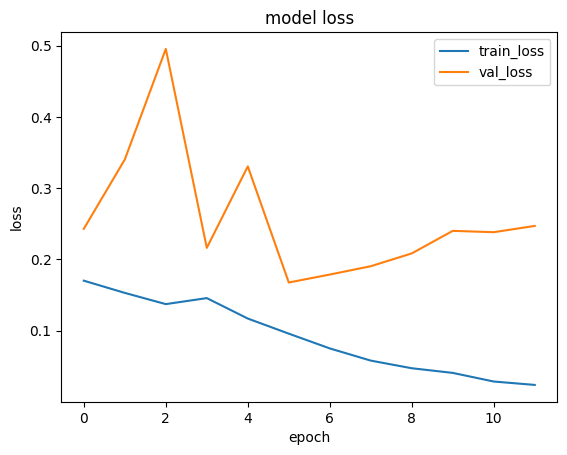

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

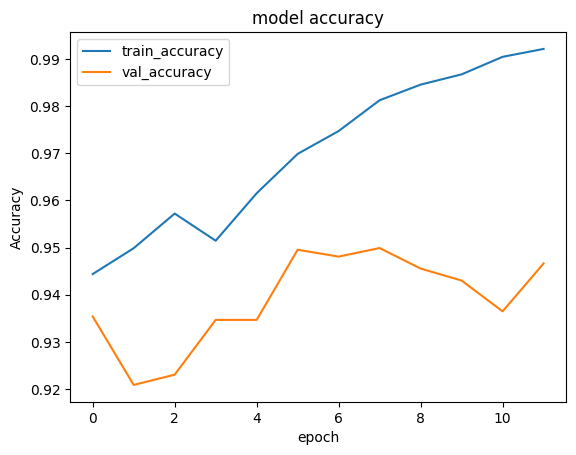

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

Model Evaluation And Testing

In [37]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [38]:
test_dataset = test_dataset.batch(1)

In [39]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [40]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 27s 5ms/step - loss: 0.2874 - accuracy: 0.9387 - precision: 0.9370 - recall: 0.9390 - auc: 0.9688


[0.2873886823654175,
 0.9387015104293823,
 0.936950147151947,
 0.9390154480934143,
 0.9687619209289551]

Visualizing Confusion Matrix

In [41]:
labels = []
inp = []

for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [42]:
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [43]:
labels = np.array([i[0] for i in labels])
print(labels)

[1 0 0 ... 1 0 0]


In [44]:
predicted = model.predict(np.array(inp)[:,0,...])
print(predicted[:,0])

87/87 [==============================] - 1s 15ms/step
[9.5653552e-01 5.8486075e-06 1.4049416e-06 ... 9.0276742e-01 1.8867276e-11
 2.4234571e-06]


[[1310   87]
 [  82 1278]]


Text(0.5, 14.722222222222216, 'Predicted')

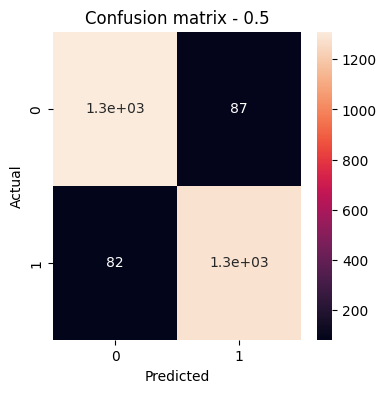

In [46]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(4,4))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

ROC Plots

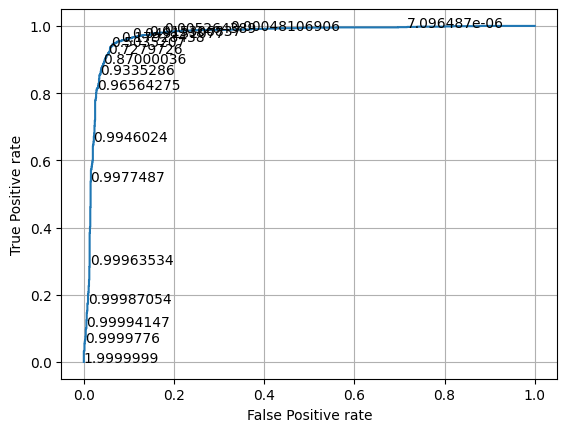

In [49]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])

plt.show()

Model Prediction

In [50]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 15s 15s/step


3.883826e-06

In [51]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

1/1 [==============================] - 0s 23ms/step


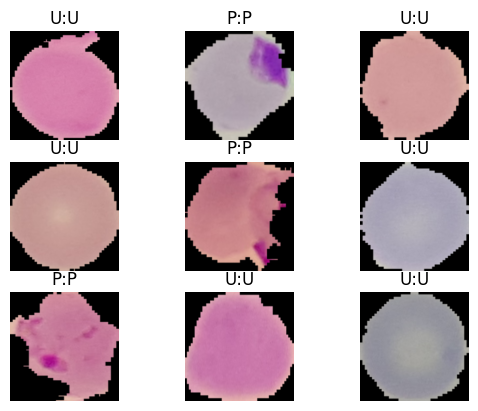

In [52]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0]))+ ":" + str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')